#### Data Loading

In [29]:
# 라이브러리를 수정할 때마다 autoreload
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/workspace/2024_AI_BEMS/YiUmGoV2/aircon_control')
import data_preprocessing as DP
import utility as Util

import numpy as np
import pandas as pd
from copy import deepcopy
from scipy.optimize import curve_fit
import plotly.graph_objects as go

######## 1. CSV 데이터셋 위치
buildingID, buildingName = 'B0008', '용학초등학교'
file_path = '/workspace/2024_AI_BEMS/YiUmGoV2/aircon_control/Aircon_Power_Emulator_241111/data_colec_h_202410141057_B0008.csv'
#########
df_buildID = pd.read_csv(file_path)
df_buildID['colec_dt'] = pd.to_datetime(df_buildID['colec_dt']).dt.floor('min')  # 분 이하는 제거
print(f"csv dataset: {file_path}")
print(f"timestamp(first~last): {df_buildID['colec_dt'].iloc[0]} ~ {df_buildID['colec_dt'].iloc[-1]}")
print(f"timestamp(min~max):    {df_buildID['colec_dt'].min()} ~ {df_buildID['colec_dt'].max()}")

######## 2. 분석 기간 설정
print(f"겨울철 분석 기간: 2023.11.15. ~ 2024.2.16.")
start_date, end_date = pd.to_datetime('2023-11-15 00:00:00'), pd.to_datetime('2024-02-16 00:00:00')

#print(f"여름철 분석 기간: 2024.6.15. ~ 2024.9.16.")
#start_date, end_date = pd.to_datetime('2024-06-15 00:00:00'), pd.to_datetime('2024-09-16 00:00:00')
########

print(f"timestamp(start~end):  {start_date} ~ {end_date}")
df_raw_all = df_buildID[(df_buildID['colec_dt'] >= start_date) & (df_buildID['colec_dt'] <= end_date)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
csv dataset: /workspace/2024_AI_BEMS/YiUmGoV2/aircon_control/Aircon_Power_Emulator_241111/data_colec_h_202410141057_B0008.csv
timestamp(first~last): 2023-01-01 00:00:00 ~ 2024-10-14 10:30:00
timestamp(min~max):    2023-01-01 00:00:00 ~ 2024-10-14 10:30:00
겨울철 분석 기간: 2023.11.15. ~ 2024.2.16.
timestamp(start~end):  2023-11-15 00:00:00 ~ 2024-02-16 00:00:00


### EHP 데이터 클렌징(분석 기간 데이터)

In [30]:
######## 3. 특정 EHP 선택
device_name_EHP = 'EHP-2'  # target EHP name
devID, device_name = 2003, 'EHP-2'  # 교실, 행정실, 교무실 등
########

# 선택된 EHP의 분석 기간 데이터에 대한 클렌징 실시

tag_dict = {30001: '현재 출력', 40004: '전체누적사용량_차', 40007: '역송전력량', 50001: '역률', 202202: 'selfcheck'}
Util.print_tagCD(df_raw_all, devID)

# 순간 변동에 민감한 {30001: '현재 출력'} 대신에, 전체누적사용량_차를 사용하여 전력 오류 줄이기
#tag_dict = {30001: '현재 출력'}
tag_dict = {40004: '전체누적사용량_차'}  
tag_dict = {key: f"{value}@{device_name}" for key, value in tag_dict.items()}
# dictionary를 이용해 각 태그 데이터를 선택
tags = {key: Util.select_devID_tagCD(df_raw_all, devID, tagCD=key) for key in tag_dict.keys()}
df_temp = Util.calc_tagCD_diff(tags[40004])  # '전체누적사용량_차'
df_temp['colec_val'] = df_temp['colec_val'] * 1/0.25 # kwH에서 kW로 변환(15분 단위)
tags[40004] = df_temp

# 그래프를 그리기 위해 필요한 데이터를 리스트로 변환
tag_data = [tags[key] for key in tag_dict.keys()]
tag_names = [tag_dict[key] for key in tag_dict.keys()]
Util.plot_dfL_devID_tagCD(tag_data, tag_names, device_name, createFig=False)

df_EHP_raw = pd.DataFrame(data=tag_data[0]['colec_val'].values, index=tag_data[0]['colec_dt'], columns=['value'])
# 음수 보정 --> 음수는 결측치로 처리하고, 이후 한꺼번에 보간 처리
df_EHP_raw.loc[df_EHP_raw['value'] < 0, 'value'] = np.nan
# df_EHP 선형 보간
df_EHP, df_EHP_is_missing, df_EHP_nan_counts_df, df_EHP_missing_ratio = DP.preprocess(df_EHP_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간

### EHP 피팅 구간을 찾기 위해 전체 데이터 플롯
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_EHP.index, y=df_EHP['value'], mode='lines+markers', name='EHP'))
fig.update_layout(title=f'EHP Data: {device_name}', xaxis_title='Date', yaxis_title='Power (kW)', showlegend=True)
fig.show()

tagCD list:  [202202  30001  40004  50001]


### 에어컨 합산 모델링으로 EHP 측정치 커브 피팅: 일정구간(span) 단위로 처리

<Axes: xlabel='colec_dt'>

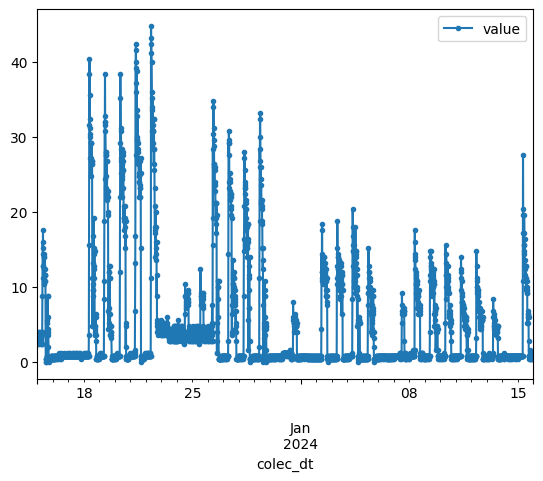

In [33]:
######## 4. 특정 EHP에 연결된 에어컨 목록 설정, 분석 기간 설정(약 1달 단위)
if device_name_EHP == 'EHP-2':
    devIDs = [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6055, 6057, 6059, 6061, 6063, 6064, 6092, 6096, 6098, 6100, 6102]
    device_names = ["행정실2_본203", "행정실1_본203", "탕비실_본204-2", "교무실2_본202", "교무실1_본202", "교장실_본201", "학교운영위원회실_본212", "2-1반_본304", "2-1반_본304", "전산실_본303", "인쇄실_본302", "스튜디오_본301-1", "방송실_본301", "위클래스_후201", "5학년교사연구실_본410", "2학년교사연구실_본311", "위클래스_본211", "1학년교사연구실_본109"]

# 겨울철 분석 기간: 2023.11.15. ~ 2024.2.16.
#date0, date1 = '2023-11-15 00:00:00', '2023-12-16 00:00:00'
date0, date1 = '2023-12-15 00:00:00', '2024-01-16 00:00:00'
#date0, date1 = '2024-01-15 00:00:00', '2024-02-16 00:00:00'

# 여름철 분석 기간: 2024.6.15. ~ 2024.9.16.
#date0, date1 = '2024-06-15 00:00:00', '2024-07-16 00:00:00'
#date0, date1 = '2024-07-15 00:00:00', '2024-08-16 00:00:00'
#date0, date1 = '2024-08-15 00:00:00', '2024-09-16 00:00:00'
########

# 1달씩 데이터 패턴이 정상적인지 간단하게 들여다 보기

start_date, end_date = date0, date1
df_EHP_span = df_EHP[(df_EHP.index >= start_date) & (df_EHP.index <= end_date)]
df_EHP_span.plot(marker='.')

In [ ]:
# 에어컨 합산 모델링 준비
Temp_dict, offON_mask_dict = {}, {}  # 에어컨 합산 모델링용
df_Temp_dict, df_offON_mask_dict = {}, {}  # 에어컨 제어 절감효과 계산용

df_offON_mask_all = pd.DataFrame(0, index=df_EHP_span.index, columns=['value'])  # df_offON_mask를 모두 모은 데이터프레임
for devID, device_name in zip(devIDs, device_names):
#for devID, device_name in zip([6003], ['유치원교사실_후108']):
    print(f"devID: {devID= }, device_name: {device_name= }")

    tag_dict = {100001: '운전선택탭', 100002: '냉난방모드', 100003: '현재온도', 100004: '희망온도'}
    tags = {key: Util.select_devID_tagCD(df_raw_all, devID, tagCD=key) for key in tag_dict.keys()}
    tag_data = [tags[key] for key in tag_dict.keys()]
    tag_names = [tag_dict[key] for key in tag_dict.keys()]

    df_offON_raw = pd.DataFrame(data=tag_data[0]['colec_val'].values, index=tag_data[0]['colec_dt'], columns=['value'])
    df_coolHeat_raw = pd.DataFrame(data=tag_data[1]['colec_val'].values, index=tag_data[1]['colec_dt'], columns=['value'])
    df_tCur_raw = pd.DataFrame(data=tag_data[2]['colec_val'].values, index=tag_data[2]['colec_dt'], columns=['value'])
    df_tSet_raw = pd.DataFrame(data=tag_data[3]['colec_val'].values, index=tag_data[3]['colec_dt'], columns=['value'])

    # 음수 보정 --> 음수는 결측치로 처리하고, 이후 한꺼번에 보간 처리
    df_offON_raw.loc[df_offON_raw['value'] < 0, 'value'] = np.nan
    df_coolHeat_raw.loc[df_coolHeat_raw['value'] < 0, 'value'] = np.nan
    df_tCur_raw.loc[df_tCur_raw['value'] < 0, 'value'] = np.nan
    df_tSet_raw.loc[df_tSet_raw['value'] < 0, 'value'] = np.nan

    # zero가 연속된 구간을 찾아서 리스트로 저장
    df_tCur_zero, _, _, _ = DP.preprocess(df_tCur_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='zero')
    zero_sequence_intervals = DP.find_zero_sequence_intervals(df_tCur_zero, min_zero_streak=4*1)  # 0이 1시간 이상 연속된 구간 찾기

    # df_offON 선형 보간
    df_offON, df_offON_is_missing, df_offON_nan_counts_df, df_offON_missing_ratio = DP.preprocess(df_offON_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
    df_offON.loc[df_offON['value'] > 0, 'value'] = 1
    # df_offON.value가 0을 유지하다가 1로 올라가는 지점을 ON으로 추가 설정
    df_offON['value'] = df_offON['value'].mask((df_offON['value'] == 0) & (df_offON['value'].shift(-1) == 1), 1)
    # df_offON.value가 1를 유지하다가 0로 떨어지는 지점을 ON으로 추가 설정
    df_offON['value'] = df_offON['value'].mask((df_offON['value'] == 0) & (df_offON['value'].shift(1) == 1), 1)

    df_coolHeat, df_coolHeat_is_missing, df_coolHeat_nan_counts_df, df_coolHeat_missing_ratio = DP.preprocess(df_coolHeat_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
    df_tCur, df_tCur_is_missing, df_tCur_nan_counts_df, df_tCur_missing_ratio = DP.preprocess(df_tCur_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
    df_tSet, df_tSet_is_missing, df_tSet_nan_counts_df, df_tSet_missing_ratio = DP.preprocess(df_tSet_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간

    #  df_offON_virtual 생성
    df_offON_virtual = DP.generate_df_offON_virtual(df_tCur, df_coolHeat, df_offON)
    df_offON_adj = df_offON.copy()
    df_offON_adj['value'] = ((df_offON['value'] > 0) | (df_offON_virtual['value'] > 0)).astype(int)

    # Generate tEnv from df_tCur and df_offON_adj
    df_tEnv = DP.generate_tEnv_from_df_tCur(df_tCur, df_offON_adj)

    # zero_sequence_intervals 구간을 적용하여 보정
    for start_time, end_time in zero_sequence_intervals:
        df_offON.loc[start_time:end_time, 'value'] = 0
        df_offON_virtual.loc[start_time:end_time, 'value'] = 0
        df_offON_adj.loc[start_time:end_time, 'value'] = 0
        #df_coolHeat.loc[start_time:end_time, 'value'] = 0
        df_tCur.loc[start_time:end_time, 'value'] = 0
        df_tEnv.loc[start_time:end_time, 'value'] = 0
        df_tSet.loc[start_time:end_time, 'value'] = 0

    #####
    start_date, end_date = date0, date1
    #####

    df_offON_span = df_offON[(df_offON.index >= start_date) & (df_offON.index <= end_date)]
    df_offON_virtual_span = df_offON_virtual[(df_offON_virtual.index >= start_date) & (df_offON_virtual.index <= end_date)]
    df_offON_adj_span = df_offON_adj[(df_offON_adj.index >= start_date) & (df_offON_adj.index <= end_date)]

    df_coolHeat_span = df_coolHeat[(df_coolHeat.index >= start_date) & (df_coolHeat.index <= end_date)]
    df_tCur_span = df_tCur[(df_tCur.index >= start_date) & (df_tCur.index <= end_date)]
    df_tEnv_span = df_tEnv[(df_tEnv.index >= start_date) & (df_tEnv.index <= end_date)]
    df_tSet_span = df_tSet[(df_tSet.index >= start_date) & (df_tSet.index <= end_date)]

    legendList = ['offON', 'offON_virtual', 'offON_adj', 'coolHeat', 'tCur', 'tEnv', 'tSet']
    ###Util.plot_dfList_devID_tagCD([df_offON_span+18, df_offON_virtual_span+18, df_offON_adj_span+18, df_coolHeat_span, df_tCur_span, df_tEnv_span, df_tSet_span], legendList, device_name, createFig=True, W=None, H=400)

    ######
    df_offON_mask = df_offON_span  #df_offON_adj_span.copy()
    #df_offON_mask = df_offON_adj_span  # df_offON_adj_span()의 정확도가 떨어짐
    ######
    df_offON_mask_all = pd.concat([df_offON_mask_all, df_offON_mask[df_offON_mask['value'] == 1]])  # EHP 파형과 여러 에어컨 제어가 일치했는지 일괄 확인용

    # Tinit 계산
    df_Tinit = df_tEnv_span['value']  #* df_offON_mask['value']
    Tinit = df_Tinit.values
    # Tset 계산
    df_Tset = df_tSet_span['value']  #* df_offON_mask['value']
    Tset = df_Tset.values
    # Toutdoor 계산
    df_Toutdoor = df_tEnv_span['value']  #* df_offON_mask['value']
    Toutdoor = df_Toutdoor.values

    ##### 각각의 devID 마다, Temperature profile과 ON/OFF mask 저장
    Temp_dict[devID] = [Tinit, Tset, Toutdoor]
    offON_mask_dict[devID] = df_offON_mask['value'].values
    
    df_Temp_dict[devID] = [df_Tinit, df_Tset, df_Toutdoor]
    df_offON_mask_dict[devID] = df_offON_mask
    #####

    # 개별 에어컨 온도 그리기
    """import plotly.graph_objects as go

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_Tinit.index, y=df_Tinit, mode='lines+markers', name='df_Tinit'))
    fig.add_trace(go.Scatter(x=df_Tset.index, y=df_Tset, mode='lines+markers', name='df_Tset'))
    fig.add_trace(go.Scatter(x=df_Toutdoor.index, y=df_Toutdoor, mode='lines+markers', name='df_Toutdoor'))
    fig.add_trace(go.Scatter(x=df_offON_mask.index, y=df_offON_mask['value'], mode='lines+markers', name='df_offON_mask'))
    fig.add_trace(go.Scatter(x=df_tEnv_span.index, y=df_tEnv_span['value'], mode='lines+markers', name='df_tEnv_span'))
    fig.add_trace(go.Scatter(x=df_EHP_span.index, y=df_EHP_span['value']*2, mode='lines+markers', name='df_EHP_span'))
    
    fig.update_layout(
        title=f'{devID}, {device_name}',
        xaxis_title='Time',
        yaxis_title='Value',
        legend=dict(
            x=0.01,
            y=0.98,
            traceorder='normal',
            bgcolor='rgba(255, 255, 255, 0.5)',
            bordercolor='rgba(0, 0, 0, 0.5)',
            borderwidth=1
        ),
        height=400
    )
    fig.show()"""
    
print(Temp_dict.keys())

# EHP 파형과 여러 에어컨 제어가 일치했는지 일괄 확인용 
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_EHP_span.index, y=df_EHP_span['value'], mode='lines+markers', name='df_EHP_span'))
fig.add_trace(go.Scatter(x=df_offON_mask_all.index, y=df_offON_mask_all['value']*2, mode='markers', name='df_offON_mask_all'))
fig.update_layout(
    title=f'{device_name_EHP} vs aircon offON control',
    xaxis_title='Time',
    yaxis_title='Power (kW)',
    legend=dict(
        x=0.01,
        y=0.98,
        traceorder='normal',
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.5)',
        borderwidth=1
    ),
    height=400
)
fig.show()


################
# Temp_dict를 체크하여 후속 오류 방지: nan or empty list
def check_Temp_dict_for_nan_or_empty(temp_dict):
    keys_with_nan_or_empty = []
    for key, values in temp_dict.items():
        for value in values:
            if isinstance(value, np.ndarray):
                if np.isnan(value).any():
                    keys_with_nan_or_empty.append(key)
                    break
            elif value == []:
                keys_with_nan_or_empty.append(key)
                break
    return keys_with_nan_or_empty

keys_with_nan_or_empty = check_Temp_dict_for_nan_or_empty(Temp_dict)
if keys_with_nan_or_empty:
    print(f"Keys with nan or empty list: {keys_with_nan_or_empty}")
else:
    print(">>> No keys with nan or empty list found in Temp_dict <<<")


################
# single_aircon, sum_aircon power_consumption_model을 구한 뒤, EHP_span로 curve fitting
def single_aircon_power_consumption_model(tau, Cinit, Coutdoor, Pbase_aircon, Tinit, Tset, Toutdoor, offON_mask):
    
    # tau ~ 10min
    # tau에 해당하는 time_control 구하는 법 time_control = tau * ln( (Tinit - Tset) / 1oC )
    # tau ~ 10min --> time_control ~ 16분 --> 1 time step
    n = len(offON_mask)
    t_total = np.arange(n)
    y_total = np.zeros(n)

    # Find non-zero segments in offON_mask
    segments = []
    in_segment = False
    for i in range(n):
        if offON_mask[i] != 0 and not in_segment:
            # Start of a new segment
            start = i
            in_segment = True
        elif offON_mask[i] == 0 and in_segment:
            # End of a segment
            end = i
            segments.append((start, end))
            in_segment = False
    if in_segment:
        # If mask ends with a non-zero segment
        end = n
        segments.append((start, end))
    
    # Process each segment
    for (offset, end) in segments:
        interval = end - offset
        # Tinit_segment, Tset_segment, Toutdoor_segment 은 모두 시간 프레임에서 일치하는 것으로 설정함
        Tinit_segment = Tinit[offset:offset+interval]
        Tset_segment = Tset[offset:offset+interval]
        Toutdoor_segment = Toutdoor[offset:offset+interval]
        t_segment = np.arange(interval)
        ###
        # 여름철: Tinit~30oC, Tset~24oC, Toutdoor~35oC
        # 겨울철: Tinit~20oC, Tset~24oC, Toutdoor~17oC
        # 여름철과 겨울철에 동시에 적용하기 위해 abs() 함수를 사용함
        y_segment = Cinit * abs(Tinit_segment - Tset_segment) * np.exp(-t_segment / tau) + Coutdoor * abs(Toutdoor_segment - Tset_segment)
        # Place y_segment into y_total
        y_total[offset:offset+interval] = y_segment

    y_total = y_total + Pbase_aircon * offON_mask  # Pbase_aircon: 에어컨 기본 전력소비량

    # Visualize : single aircon power consumption model
    ###
    """import plotly.graph_objects as go

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t_total, y=y_total, name='y(t)', mode='lines+markers'))
    fig.add_trace(go.Scatter(x=t_total, y=offON_mask, name='ON/OFF mask', line=dict(dash='dash'), mode='lines+markers'))
    fig.add_trace(go.Scatter(x=t_total, y=Tinit, name='Initial Temp', mode='lines+markers'))
    fig.add_trace(go.Scatter(x=t_total, y=Tset, name='Set Temp', mode='lines+markers'))
    fig.add_trace(go.Scatter(x=t_total, y=Toutdoor, name='Outdoor Temp', mode='lines+markers'))

    fig.update_layout(
        title='Temperature Profiles and ON/OFF mask over time',
        xaxis_title='Time',
        yaxis_title='Temperature',
        showlegend=True,
        width=None,
        height=300
    )
    fig.show()"""

    return y_total


# 하나의 devID에 대한 모델링 테스트
"""
Tinit, Tset, Toutdoor = Temp_dict[devID]
offON_mask = offON_mask_dict[devID]
tau = 10./15.  # tau ~ 10min
Cinit = 1
Coutdoor = 5
Pbase = 0.0
print(f"devID: {devID= }")
Pow_each_aircon = single_aircon_power_consumption_model(tau, Cinit, Coutdoor, Pbase_aircon, Tinit, Tset, Toutdoor, offON_mask)
"""

# 여러 개의 devID에 대해서 합산하는 함수
def sum_aircon_power_consumption_model(t, tau, Temp_dict, offON_mask_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP):
    Ptotal = np.zeros(len(t))

    # 각각의 devID에 대해서 Pow_devID를 계산하고 모두 합산
    for devID in Temp_dict.keys():
        Tinit, Tset, Toutdoor = Temp_dict[devID]
        offON_mask = offON_mask_dict[devID]
        Pow_each = single_aircon_power_consumption_model(tau, Cinit, Coutdoor, Pbase_aircon, Tinit, Tset, Toutdoor, offON_mask)
        Ptotal = Ptotal + Pow_each
        #print(f"{devID= }\n {Ptotal= }")

    Ptotal = Ptotal + Pbase_EHP  # Pbase: EHP 기본 전력소비량
    return Ptotal

# 여러 개의 devID에 대한 모델링 테스트
"""
tau = 10./15.  # tau ~ 10min
Cinit = 1
Coutdoor = 5
Pbase = 0.0
print(f"all devID= {Temp_dict.keys()}")
Pow_sum_aircon = sum_aircon_power_consumption_model(t, tau, Temp_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)
"""

# 커브 피팅에서의 함수 형태: EHP_span ~ fn(t, Cinit, Coutdoor, Pbase)
tau = 10./15.  # tau ~ 10min  # 10
EHP_span = df_EHP_span['value'].values
t = np.arange(len(EHP_span))
#### Pbase_aircon == 0.0 으로 셋팅하고 계산
Pbase_aircon = 0.0
initial_guess = [0.1, 0.1, 0.1]  # Initial guess for Cinit, Coutdoor, (Pbase_aircon,) Pbase_EHP
popt, _ = curve_fit(  # 더 정밀하게 옵션을 셋팅해도 정확도 개선 없음
    lambda t, Cinit, Coutdoor, Pbase_EHP: sum_aircon_power_consumption_model(
        t, tau, Temp_dict, offON_mask_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP),
    t, EHP_span, 
    p0=initial_guess)
Cinit, Coutdoor, Pbase_EHP = popt
#### Pbase_aircon도 포함하여 계산 --> 적용 결과, Pbase_aircon > Pbase_EHP로 추정되어 물리적으로 무의미
"""initial_guess = [0.1, 0.1, 0.1, 0.1]  # Initial guess for Cinit, Coutdoor, (Pbase_aircon,) Pbase_EHP
popt, _ = curve_fit(
    lambda t, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP: sum_aircon_power_consumption_model(
        t, tau, Temp_dict, offON_mask_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP),
    t, EHP_span, 
    p0=initial_guess)
Cinit, Coutdoor, Pbase_aircon, Pbase_EHP = popt"""
####

# EHP 시스템 모델링 결과 확인용
Pow_sum_aircon = sum_aircon_power_consumption_model(t, tau, Temp_dict, offON_mask_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)
RMSE = np.sqrt(np.mean((EHP_span - Pow_sum_aircon)**2))
print(f"{start_date= }, {end_date= }")
print(f"Cinit: {Cinit:.4f}, Coutdoor: {Coutdoor:.4f}, Pbase_aircon: {Pbase_aircon:.4f}, Pbase_EHP: {Pbase_EHP:.4f}, {RMSE= :.2f}")

import plotly.graph_objects as go

# Create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=EHP_span, mode='lines+markers', name='EHP_span'))
fig.add_trace(go.Scatter(x=t, y=Pow_sum_aircon, mode='lines+markers',name='sum_aircon_power_consumption_model'))
# Update layout
fig.update_layout(
    title=f'{device_name_EHP} vs aircon_power_consumption_model',
    xaxis_title='Time',
    yaxis_title='Power (kW)',
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()

devID: devID= 6033, device_name: device_name= '행정실2_본203'
devID: devID= 6034, device_name: device_name= '행정실1_본203'
devID: devID= 6035, device_name: device_name= '탕비실_본204-2'
devID: devID= 6036, device_name: device_name= '교무실2_본202'
devID: devID= 6037, device_name: device_name= '교무실1_본202'
devID: devID= 6038, device_name: device_name= '교장실_본201'
devID: devID= 6039, device_name: device_name= '학교운영위원회실_본212'
devID: devID= 6055, device_name: device_name= '2-1반_본304'
devID: devID= 6057, device_name: device_name= '2-1반_본304'
devID: devID= 6059, device_name: device_name= '전산실_본303'
devID: devID= 6061, device_name: device_name= '인쇄실_본302'
devID: devID= 6063, device_name: device_name= '스튜디오_본301-1'


#### aircon_power_consumption_model을 시각화

In [ ]:
# 위에서 구한 계수를 사용하고, 기간을 하루로 설정하여 시각화 

# date0, date1 = '2024-07-04 00:00:00', '2024-07-05 00:00:00' 로 두고, 위의 루틴을 수행하여 EHP_span, Temp_dict 데이터 얻기
# devID를 변경해 가면서 aircon_power_consumption_model 고찰
t = np.arange(len(EHP_span))

devID = devIDs[4]
Tinit, Tset, Toutdoor = Temp_dict[devID]
offON_mask = offON_mask_dict[devID]

# 겨울철 계수
#tau, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP = 10./15., -0.2885, 0.3654, 0.0000, 1.0597  # tau ~ 10min
tau, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP = 10./15., -0.3006, 0.1506, 1.0807, 0.8049  # tau ~ 10min
#Cinit: -0.3006 ± 0.0869
#Coutdoor: 0.1506 ± 0.0493
#Pbase_aircon: 1.0807 ± 0.3012
#Pbase_EHP: 0.8049 ± 0.0696
#RMSE: 2.14 ± 0.29

# 여름철 계수
#tau, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP = 10./15., -0.1313, 0.1744, 0.0000, 0.5966  # tau ~ 10min

print(f"devID: {devID= }")
Pow_each_aircon = single_aircon_power_consumption_model(tau, Cinit, Coutdoor, Pbase_aircon, Tinit, Tset, Toutdoor, offON_mask)
Pow_sum_aircon = sum_aircon_power_consumption_model(t, tau, Temp_dict, offON_mask_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)

import plotly.graph_objects as go

# Create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=EHP_span, mode='lines+markers', name='EHP_power'))
fig.add_trace(go.Scatter(x=t, y=Pow_sum_aircon, mode='lines+markers',name='sum_aircon_power_consumption_model'))
fig.add_trace(go.Scatter(x=t, y=Tinit/10., mode='lines+markers', name='Temperature_init(x1/10)'))
fig.add_trace(go.Scatter(x=t, y=Tset/10., mode='lines+markers', name='Temperature_set(x1/10)'))
fig.add_trace(go.Scatter(x=t, y=Toutdoor/10., mode='lines+markers', name='Temperature_outdoor(x1/10)'))
fig.add_trace(go.Scatter(x=t, y=offON_mask, mode='lines+markers', name='offON_control'))
fig.add_trace(go.Scatter(x=t, y=Pow_each_aircon, mode='lines+markers',name='single_aircon_power_consumption_model'))

# Update layout
fig.update_layout(
    title=f'{device_name_EHP} power vs aircon_power_consumption_model({devID}, {device_names[devIDs.index(devID)]})',
    xaxis_title='Time', yaxis_title='Power (kW)', showlegend=True,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig.show()

#### 에어컨 제어 절감효과 계산
df_Temp_dict[devID], df_offON_mask_dict[devID] 를 이용

In [ ]:
from copy import deepcopy

def plot_aircon_control_and_temps(df_control_dict, devID, device_names, devIDs, df_Temp_dict, title='제어'):
    df_Tinit, df_Tset, df_Toutdoor = df_Temp_dict[devID]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_control_dict[devID].index, y=df_control_dict[devID]['value']*20, mode='lines+markers', name='Aircon offON control'))
    fig.add_trace(go.Scatter(x=df_control_dict[devID].index, y=df_Tinit, mode='lines+markers', name='Initial Temperature'))
    fig.add_trace(go.Scatter(x=df_control_dict[devID].index, y=df_Tset, mode='lines+markers', name='Set Temperature'))
    fig.add_trace(go.Scatter(x=df_control_dict[devID].index, y=df_Toutdoor, mode='lines+markers', name='Outdoor Temperature'))
    fig.update_layout(title=title + f', {device_names[devIDs.index(devID)]}', xaxis_title='Time', yaxis_title='Power Consumption (kW) / Temperature (°C)', showlegend=True)
    fig.show()

def calculate_lunch_operation_percentages(df_dict, devIDs):
    percentages = []
    for devID in devIDs:
        df = df_dict[devID]
        df.index = pd.to_datetime(df.index)
        lunch_mask = (df.index.hour == 12)
        daily_lunch_counts = df[lunch_mask].groupby(pd.Grouper(freq='D'))['value'].apply(lambda x: (x > 0).sum())
        total_lunch_counts = daily_lunch_counts.sum()
        lunch_operation_percentage = (total_lunch_counts / (len(daily_lunch_counts) * 4)) * 100
        percentages.append(lunch_operation_percentage)
    
    return percentages

print("### (제어 전) 점심시간 일상사용")
df_offON_mask__usual_dict = deepcopy(df_offON_mask_dict)
percentages = calculate_lunch_operation_percentages(df_offON_mask__usual_dict, devIDs)
print(f"\n점심시간 에어컨 가동 평균: {sum(percentages)/len(percentages):.1f}%")
devID = devIDs[0]
plot_aircon_control_and_temps(df_offON_mask__usual_dict, devID, device_names, devIDs, df_Temp_dict, title='(제어 전) 점심시간 일상사용')


print("### (제어 후) 점심시간 allOff")
df_offON_mask__allOff_dict = deepcopy(df_offON_mask_dict)
for devID in devIDs:
    df = deepcopy(df_offON_mask__allOff_dict[devID])
    df.index = pd.to_datetime(df.index)
    lunch_mask = (df.index.hour == 12)
    df.loc[lunch_mask, 'value'] = 0  # Set values to 0 during lunch time
    df_offON_mask__allOff_dict[devID] = df
percentages = calculate_lunch_operation_percentages(df_offON_mask__allOff_dict, devIDs)
print(f"\n점심시간 에어컨 가동 평균: {sum(percentages)/len(percentages):.1f}%")
devID = devIDs[0]
df_Tinit, df_Tset, df_Toutdoor = df_Temp_dict[devID]
plot_aircon_control_and_temps(df_offON_mask__allOff_dict, devID, device_names, devIDs, df_Temp_dict, title='(제어 후) 점심시간 allOff')


print("### (제어 후) 점심시간 allON")
df_offON_mask__allOn_dict = deepcopy(df_offON_mask_dict)
for devID in devIDs:
    df = deepcopy(df_offON_mask__allOn_dict[devID])
    df.index = pd.to_datetime(df.index)
    lunch_mask = (df.index.hour == 12)
    df.loc[lunch_mask, 'value'] = 1  # Set values to 1 during lunch time
    df_offON_mask__allOn_dict[devID] = df
percentages = calculate_lunch_operation_percentages(df_offON_mask__allOn_dict, devIDs)
print(f"\n점심시간 에어컨 가동 평균: {sum(percentages)/len(percentages):.1f}%")
devID = devIDs[0]
plot_aircon_control_and_temps(df_offON_mask__allOn_dict, devID, device_names, devIDs, df_Temp_dict, title='(제어 후) 점심시간 allON')


print("### (제어 후) 점심시간 20oC로 제어")
df_Temp__20oc_dict = {}
for devID in devIDs:
    df = deepcopy(df_offON_mask_dict[devID])
    df.index = pd.to_datetime(df.index)
    lunch_mask = (df.index.hour == 12)
    # Modify Tset to 26.0°C during lunch time
    df_Tinit, df_Tset, df_Toutdoor = [deepcopy(df) for df in df_Temp_dict[devID]]
    df_Tset.loc[lunch_mask] = 20.0
    df_Temp__20oc_dict[devID] = [df_Tinit, df_Tset, df_Toutdoor]
percentages = calculate_lunch_operation_percentages(df_offON_mask_dict, devIDs)
print(f"\n점심시간 에어컨 가동 평균: {sum(percentages)/len(percentages):.1f}%")
devID = devIDs[0]
plot_aircon_control_and_temps(df_offON_mask_dict, devID, device_names, devIDs, df_Temp__20oc_dict, title='(제어 후) 점심시간 20°C로 제어')

In [ ]:
# 일상적인 사용시 에너지 소비량 계산(EHP 데이터를 활용)-검증용
total_energy_EHP = sum(df_EHP['value'] * 0.25)  # kW * 0.25hour = kWh
print(f"Total Energy Consumption(actual, usual): {total_energy_EHP:.1f} kWh")

# Aircon 모델 파라미터
t = np.arange(len(EHP_span))
# 겨울철 계수
tau, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP = 10./15., -0.2885, 0.3654, 0.0000, 1.0597  # tau ~ 10min
# 여름철 계수
#tau, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP = 10./15., -0.1313, 0.1744, 0.0000, 0.5966  # tau ~ 10min

# 일상적인 사용시 에너지 소비량 계산(Aircon 모델을 활용)
Temp_dict = Temp_dict
offON_mask__usual_dict = offON_mask_dict
Pow_sum_aircon_usual = sum_aircon_power_consumption_model(t, tau, Temp_dict, offON_mask__usual_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)
total_energy_usual = sum(Pow_sum_aircon_usual * 0.25)  # kW * 0.25hour = kWh

# (제어 후) 점심시간 allOff 에너지 소비량 계산(Aircon 모델을 활용)
Temp_dict = Temp_dict
offON_mask__allOff_dict = {devID: df_offON_mask__allOff_dict[devID]['value'].values for devID in df_offON_mask__allOff_dict.keys()}
Pow_sum_aircon_allOff = sum_aircon_power_consumption_model(t, tau, Temp_dict, offON_mask__allOff_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)
total_energy_allOff = sum(Pow_sum_aircon_allOff * 0.25)  # kW * 0.25hour = kWh

# (제어 후) 점심시간 allOn 에너지 소비량 계산(Aircon 모델을 활용)
Temp_dict = Temp_dict
offON_mask__allOn_dict = {devID: df_offON_mask__allOn_dict[devID]['value'].values for devID in df_offON_mask__allOn_dict.keys()}
Pow_sum_aircon_allOn = sum_aircon_power_consumption_model(t, tau, Temp_dict, offON_mask__allOn_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)
total_energy_allOn = sum(Pow_sum_aircon_allOn * 0.25)  # kW * 0.25hour = kWh

# (제어 후) 점심시간 26°C 에너지 소비량 계산(Aircon 모델을 활용)
Temp__20oc_dict = {}
for devID in devIDs:
    df_Tinit, df_Tset, df_Toutdoor = df_Temp__20oc_dict[devID]
    Temp__20oc_dict[devID] = [df_Tinit.values, df_Tset.values, df_Toutdoor.values]
offON_mask__usual_dict = offON_mask_dict
Pow_sum_aircon_20oc = sum_aircon_power_consumption_model(t, tau, Temp__20oc_dict, offON_mask__usual_dict, Cinit, Coutdoor, Pbase_aircon, Pbase_EHP)
total_energy_20oc = sum(Pow_sum_aircon_20oc * 0.25)  # kW * 0.25hour = kWh

print(f"Total Energy Consumption(model, usual): {total_energy_usual:.1f} kWh")
print(f"Total Energy Consumption(model, allOn): {total_energy_allOn:.1f} kWh")
print(f"Total Energy Consumption(model, allOff): {total_energy_allOff:.1f} kWh")
print(f"Total Energy Consumption(model, 20°C): {total_energy_20oc:.1f} kWh")
print('')
accuracy_percentage = (total_energy_EHP - total_energy_usual) / total_energy_EHP * 100
print(f"accuracy Percentage: {accuracy_percentage:.1f}%")
allOn_percentage = (total_energy_usual - total_energy_allOn) / total_energy_usual * 100
print(f"allOn Overhead Percentage: {allOn_percentage:.1f}%")
allOff_percentage = (total_energy_usual - total_energy_allOff) / total_energy_usual * 100
print(f"allOff Reduction Percentage: {allOff_percentage:.1f}%")
Tset_20oC_percentage = (total_energy_usual - total_energy_20oc) / total_energy_usual * 100
print(f"Tset_20°C Reduction Percentage: {Tset_20oC_percentage:.1f}%")

In [ ]:
# Create figure for power consumption comparison
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_EHP.index, y=df_EHP['value'], mode='lines+markers', name='Actual EHP Power'))
fig.add_trace(go.Scatter(x=df_EHP.index, y=Pow_sum_aircon_usual, mode='lines+markers', name='Model - Usual Operation'))
fig.add_trace(go.Scatter(x=df_EHP.index, y=Pow_sum_aircon_allOff, mode='lines+markers', name='Model - All Off at Lunch'))
fig.add_trace(go.Scatter(x=df_EHP.index, y=Pow_sum_aircon_allOn, mode='lines+markers', name='Model - All On at Lunch'))
fig.add_trace(go.Scatter(x=df_EHP.index, y=Pow_sum_aircon_20oc, mode='lines+markers', name='Model - 20°C at Lunch'))
fig.update_layout(title='Power Consumption Comparison', xaxis_title='Time', yaxis_title='Power (kW)', showlegend=True)

# Show the plot
fig.show()  


#### 에어컨 모델링을 위한 시상수 계산
* 데이터에서 시상수를 이론적으로 계산 가능하나,
  * 샘플링이 15분 단위이어서 curve fitting이 부정확
  * 샘플링 주가가 너무 커서 오류가 많음. 일정한 상수로 가정함
  * 가정용 고효율 모델 ~ 5분
  * 가정용 일반 모델 ~ 10분
  * 상업용 대형 모델 ~ 20분

In [ ]:
# 기간 설정을 위해서, df_tCur_raw와 df_offON_raw 전체 플롯하고, 에어컨 냉방 시상수 계산을 위한 구간을 선정

# Create figure
fig = go.Figure()

# Add trace for temperature values
fig.add_trace(go.Scatter(x=df_tCur_raw.index, y=df_tCur_raw['value'], mode='lines+markers', name='Current Temperature'))
fig.add_trace(go.Scatter(x=df_offON_raw.index, y=df_offON_raw['value']+24, mode='lines+markers', name='Operation Status'))
# Update layout
fig.update_layout(title=f'Raw Current Temperature Data: {device_name}', xaxis_title='Date', yaxis_title='Temperature (°C)', showlegend=True)
# Show the plot
fig.show()

In [ ]:
%load_ext autoreload
%autoreload 

start_date, end_date = '2024-07-01', '2024-07-15'  # 2024년 7월 1일부터 15일까지에서 에너컨 냉방 시상수 계산

# EHP-1에 연결된 에어컨 목록: 일부 에어컨은 데이터통신 안됨
# tau_cooling_avg_list= [nan, nan, nan, 0.02141730719264794, 0.021396170730480224, 0.02158334841036927, 0.02137445282199779, 0.021455724261621508, 0.021439385672945566, 0.02138857381701961, 0.021518734936728266, 0.021492008151767578, 0.021521110583340587, 0.021630110830587145, 0.021271518266065718, 0.021452597660100152, 0.021316261789862682, nan, nan, 0.021403404328378454, 0.0213483950705997, 0.021375839225644455, 0.021304073077900516, 0.021353782125282255]
# tau_cooling mean, std: 0.021423, 0.000092
devIDs = [6011, 6012, 6047, 6048, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6105, 6106, 6117, 6054, 6056, 6058, 6060, 6062]
device_names = ['체육관후면좌_후210', '체육관전면좌_후210', '체육관후면우_후210', '체육관전면우_후210', '세척실_급103', '조리실2_급105', '조리실1_급105', '영양사실_급106', '휴게실_급109-1', '전처리실_급109', '식품창고_급107', '식당중2_급101', '식당중1_급101', '식당후면2_급101', '식당전4_급101', '식당전3_급101', '식당전2_급101', '식당전1_급101', '식당중3_급101']
devIDs_NA = [6141, 6142, 6143, 6119, 6121]
device_names = ['체육관교사실_후211', '체육관방송실_후214', '체육관준비실_후213', '식당후면1_급101', '이벤트식당_급101-1']

# EHP-2에 연결된 에어컨 목록
#tau_cooling_avg_list= [0.02145638587474209, 0.02157598846269301, nan, nan, nan, 0.021635138314053132, 0.021556236528416293, 0.021508934748809026, 0.02126630012969032, 0.02179485703523955, 0.02144688584752645, nan, nan, 0.021245830138337033, 0.021467983219818847, 0.021522093430371238, 0.021296708980242225, 0.021457298464529935]
#tau_cooling mean, std: 0.021479, 0.000146
devIDs = [6033, 6034, 6035, 6036, 6037, 6038, 6039, 6055, 6057, 6059, 6061, 6063, 6064, 6092, 6096, 6098, 6100, 6102]
device_names = ["행정실2_본203", "행정실1_본203", "탕비실_본204-2", "교무실2_본202", "교무실1_본202", "교장실_본201", "학교운영위원회실_본212", "2-1반_본304", "2-1반_본304", "전산실_본303", "인쇄실_본302", "스튜디오_본301-1", "방송실_본301", "위클래스_후201", "5학년교사연구실_본410", "2학년교사연구실_본311", "위클래스_본211", "1학년교사연구실_본109"]

# EHP-4에 연결된 에어컨 목록
#tau_cooling_avg_list= [0.021518634403367518, nan, nan, nan, nan, nan, 0.021633047159572132, 0.021460875587451484, 0.02122262998301746, 0.02137798715371326, nan]
#tau_cooling mean, std: 0.021443, 0.000138
#devIDs = [6116, 6002, 6003, 6004, 6005, 6006]
#device_names = ['아라반_후103', '유치원복도1', '유치원교사실_후108', '누리반_후107', '한울반_후106', '가람반_후105']
#devIDs_NA = [6118, 6120, 6122, 6123, 6144]
#device_names_NA = ['마루반_후102', '유치원조리실_후101', '유희실', '유치원도서실', '유치원복도2']


tau_cooling_avg_list = []
for (devID, device_name) in zip(devIDs, device_names):
    tag_dict = {100001: '운전선택탭', 100002: '냉난방모드', 100003: '현재온도', 100004: '희망온도'}
    tags = {key: Util.select_devID_tagCD(df_raw_all, devID, tagCD=key) for key in tag_dict.keys()}
    tag_data = [tags[key] for key in tag_dict.keys()]
    tag_names = [tag_dict[key] for key in tag_dict.keys()]

    df_offON_raw = pd.DataFrame(data=tag_data[0]['colec_val'].values, index=tag_data[0]['colec_dt'], columns=['value'])
    df_tCur_raw = pd.DataFrame(data=tag_data[2]['colec_val'].values, index=tag_data[2]['colec_dt'], columns=['value'])

    # 음수 보정 --> 음수는 결측치로 처리하고, 이후 한꺼번에 보간 처리
    df_offON_raw.loc[df_offON_raw['value'] < 0, 'value'] = np.nan
    df_tCur_raw.loc[df_tCur_raw['value'] < 0, 'value'] = np.nan

    # df_offON 선형 보간
    df_offON, df_offON_is_missing, df_offON_nan_counts_df, df_offON_missing_ratio = DP.preprocess(df_offON_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
    df_offON.loc[df_offON['value'] > 0, 'value'] = 1
    # df_offON.value가 0을 유지하다가 1로 올라가는 지점을 ON으로 추가 설정
    df_offON['value'] = df_offON['value'].mask((df_offON['value'] == 0) & (df_offON['value'].shift(-1) == 1), 1)
    # df_offON.value가 1를 유지하다가 0로 떨어지는 지점을 ON으로 추가 설정
    df_offON['value'] = df_offON['value'].mask((df_offON['value'] == 0) & (df_offON['value'].shift(1) == 1), 1)

    df_tCur, df_tCur_is_missing, df_tCur_nan_counts_df, df_tCur_missing_ratio = DP.preprocess(df_tCur_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간

    df_tCur_Jul = df_tCur[(df_tCur.index >= start_date) & (df_tCur.index <= end_date)]
    df_offON_Jul = df_offON[(df_offON.index >= start_date) & (df_offON.index <= end_date)]

    # Find segments where value changes from 0 to 1
    change_points = df_offON_Jul[(df_offON_Jul['value'] == 1) & (df_offON_Jul['value'].shift(1) == 0)].index

    # Initialize list to store filtered segments
    filtered_segments = []

    # For each change point, check if next 4*5 values are 1
    for point in change_points:
        idx = df_offON_Jul.index.get_loc(point)
        if idx + 1 <= len(df_offON_Jul):  # Check if we have enough values ahead
            segment = df_offON_Jul.iloc[idx:idx+4*5]
            if all(segment['value'] == 1):  # Check if all 4*5 values are 1, 5시간 지속 여부
                # Get corresponding temperature values
                temp_segment = df_tCur_Jul.iloc[idx:idx+4*3]['value']  # 2시간 구간 취득
                filtered_segments.append(temp_segment)
                # Store the time range
                start_time = segment.index[0]
                end_time = segment.index[-1]
                print(f"Segment: {start_time} to {end_time}")

    print(f"Total number of filtered segments: {len(filtered_segments)}")

    # Calculate tau for each filtered segment
    tau_cooling_list = []
    for segment in filtered_segments:
        tau_cooling = DP.fit_exponential(segment.values, mode='decay')  # Using growth mode since temperature increases
        tau_cooling_list.append(tau_cooling)

    print("Calculated tau values:")
    for i, tau in enumerate(tau_cooling_list, 1):
        print(f"Segment {i}: tau = {tau:.5f}")

    tau_cooling_avg = np.mean(tau_cooling_list)
    text = f"{devID}, {device_name}: {tau_cooling_avg=:.5f} points, {tau_cooling_avg*15=:.5f} mins"
    print(f"{text}")
    tau_cooling_avg_list.append(tau_cooling_avg)

    # Create figure using plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_tCur_Jul.index, y=df_tCur_Jul['value'], name='Temperature', mode='markers', marker=dict(color='red', size=3)))
    fig.add_trace(go.Scatter(x=df_offON_Jul.index, y=df_offON_Jul['value'] + 20, name='ON/OFF Status', mode='markers', marker=dict(color='blue', size=3)))
    fig.update_layout(title=f'Temperature and ON/OFF Status: {device_name}', xaxis_title='Time', yaxis_title='Temperature (°C)', height=300, showlegend=True)
    fig.show()

print(f"{tau_cooling_avg_list= }")
# Remove nan values and calculate mean and std
tau_cooling_avg_filtered = [x for x in tau_cooling_avg_list if not np.isnan(x)]
print(f"tau_cooling mean, std: {np.mean(tau_cooling_avg_filtered):.6f}, {np.std(tau_cooling_avg_filtered):.6f}")